## Sinusoidal forcing

In [45]:

import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import jax.scipy as jsp
import jax.scipy.optimize as jsp_opt
import optax 
import jaxopt
from jaxopt import ScipyBoundedMinimize
import matplotlib.pyplot as plt
import jax

@jit
def mpm(E):
    # nsteps
    dt = 0.02
    nsteps = 1000
    
    # mom tolerance
    tol = 1e-12

    # Domain
    L = 25

    # Material properties
    # E = 100
    rho = 1

    # Computational grid
    nelements = 13 # number of elements
    dx = L / nelements # element length

    # Create equally spaced nodes
    x_n = jnp.linspace(0, L, nelements+1)
    nnodes = len(x_n)

    # Set-up a 2D array of elements with node ids
    elements = jnp.zeros((nelements, 2), dtype = int)
    for nid in range(nelements):
        elements = elements.at[nid,0].set(nid)
        elements = elements.at[nid,1].set(nid+1)

    

    # Create material points at the center of each element
    nparticles = nelements  # number of particles
    # Id of the particle in the central element
    pmid = 6

    # Material point properties
    x_p      = jnp.zeros(nparticles)       # positions
    vol_p    = jnp.ones(nparticles) * dx   # volume
    mass_p   = vol_p * rho                 # mass
    stress_p = jnp.zeros(nparticles)       # stress
    strain_p = jnp.zeros(nparticles)       # strain
    vel_p    = jnp.zeros(nparticles)       # velocity
    
    # Create particle at the center
    x_p      = 0.5 * (x_n[:-1] + x_n[1:])

    # Loading conditions
    v0 = 0.1             # initial velocity
    c  = jnp.sqrt(E/rho)  # speed of sound
    b1 = jnp.pi / (2 * L) # beta1
    w1 = b1 * c          # omega1
    fext = jnp.zeros(nparticles)

    # set initial velocities
    vel_p    = v0  * jnp.sin(b1 * x_p) #* jnp.ones(nparticles)#
    
    # Time steps and duration
    dt_crit = dx / c
    
    
    # results
    tt = jnp.zeros(nsteps)
    vt = jnp.zeros(nsteps)
    xt = jnp.zeros(nsteps)

    def step(i, carry):
        x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt = carry
        # reset nodal values
        mass_n  = jnp.zeros(nnodes)  # mass
        mom_n   = jnp.zeros(nnodes)  # momentum
        fint_n  = jnp.zeros(nnodes)  # internal force
        fext_n  = jnp.zeros(nnodes)  # external force

        # update particle natural coordinates
        # not necessary since operating in global coords

        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx

            # map particle mass and momentum to nodes
            mass_n = mass_n.at[nid1].set(mass_n[nid1] + N1 * mass_p[eid])
            mass_n = mass_n.at[nid2].set(mass_n[nid2] + N2 * mass_p[eid])

            mom_n = mom_n.at[nid1].set(mom_n[nid1] + N1 * mass_p[eid] * vel_p[eid])
            mom_n = mom_n.at[nid2].set(mom_n[nid2] + N2 * mass_p[eid] * vel_p[eid])
        
        # apply moment boundary conditions
        mom_n = mom_n.at[0].set(0)  # Nodal velocity v = 0 in m * v at node 0.
       
        
        # update particle velocity position and stress
        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx
            
            # nodal velocity
            nv1 = mom_n[nid1]/mass_n[nid1]
            nv2 = mom_n[nid2]/mass_n[nid2]           

             # strain rate
            grad_v = dN1 * nv1 + dN2 * nv2
            # particle dstrain
            dstrain = grad_v * dt
            strain_p = strain_p.at[eid].set(strain_p[eid] + dstrain)
            # particle volume
            vol_p = vol_p.at[eid].set((1 + dstrain) * vol_p[eid])
            # update stress using linear elastic model
            stress_p = stress_p.at[eid].set(stress_p[eid] + E * dstrain)



        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx
            # compute nodal internal force
            fint_n = fint_n.at[nid1].set(fint_n[nid1] - vol_p[eid] * stress_p[eid] * dN1)
            fint_n = fint_n.at[nid2].set(fint_n[nid2] - vol_p[eid] * stress_p[eid] * dN2)

            # compute nodal external force
            fext_n = fext_n.at[nid1].set(fext_n[nid1] + N1 * fext[eid])
            fext_n = fext_n.at[nid2].set(fext_n[nid2] + N2 * fext[eid])        

        # apply force boundary conditions
        fint_n = fint_n.at[0].set(0)  # Nodal force f = m * a, where a = 0 at node 0.
        fext_n = fext_n.at[0].set(0)

        # update nodal momentum
        mom_n = mom_n + (fint_n + fext_n)* dt

        
        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx
        # compute particle velocity
            # if (mass_n[nid1]) > tol:
            vel_p = vel_p.at[eid].set(vel_p[eid] + dt * N1 * (fint_n[nid1] + fext_n[nid1]) / mass_n[nid1])
            # if (mass_n[nid2]) > tol:
            vel_p = vel_p.at[eid].set(vel_p[eid] + dt * N2 * (fint_n[nid2] + fext_n[nid2]) / mass_n[nid2])
            # update particle position based on nodal momentum
            x_p = x_p.at[eid].set(x_p[eid] + dt * (N1 * mom_n[nid1]/mass_n[nid1] + N2 * mom_n[nid2]/mass_n[nid2]))

        # results
        vt = vt.at[i].set(vel_p[pmid])
        xt = xt.at[i].set(x_p[pmid])

        return (x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt)

    x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt = lax.fori_loop(
        0, nsteps, step, (x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt))


    return vt




In [46]:
# baseline
E = 100
target = mpm(E)

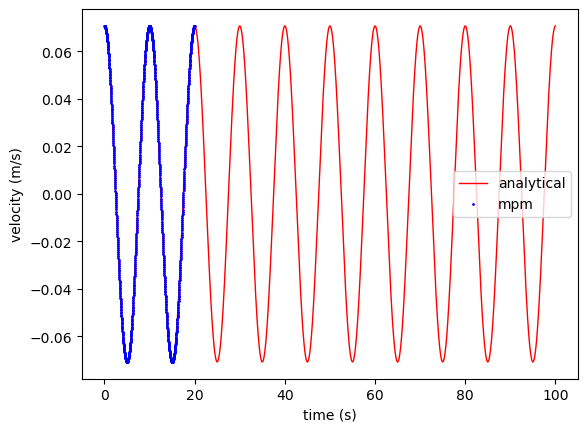

In [50]:
def axial_vibration_bar1d(L, E, rho, duration, dt, v0, x):

    # Frequency of system mode 1
    w1 = jnp.pi / (2 * L) * jnp.sqrt(E/rho)
    b1 = jnp.pi / (2 * L)

    # position and velocity in time
    tt, vt, xt = [], [], []

    nsteps = int(duration/dt)
    t = 0
    for _ in range(nsteps):
        vt.append(v0 * jnp.cos(w1 * t) * jnp.sin(b1 * x))
        xt.append(v0 / w1 * jnp.sin(w1 * t) * jnp.sin(b1 * x))
        tt.append(t)

        t += dt
    
    return tt, vt, xt

E = 100
L = 25

# analytical solution at the end of the bar
ta, va, xa = axial_vibration_bar1d(L = L, E = E, rho = 1, duration = 100, dt = 0.02, v0 = 0.1, x = 12.5)

tt = jnp.arange(0, 1000) * 0.02
plt.plot(ta, va, 'r', linewidth=1,label='analytical')
plt.plot(tt, target, 'ob', markersize=1, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

## Uniform forcing

In [66]:

import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import jax.scipy as jsp
import jax.scipy.optimize as jsp_opt
import optax 
import jaxopt
from jaxopt import ScipyBoundedMinimize
import matplotlib.pyplot as plt
import jax

@jit
def mpm(E):
    # nsteps
    dt = 0.01
    nsteps = int(10/dt)
    
    # mom tolerance
    tol = 1e-12

    # Domain
    L = 1

    # Material properties
    # E = 100
    rho = 1

    # Computational grid
    nelements = 1 # number of elements
    dx = L / nelements # element length

    # Create equally spaced nodes
    x_n = jnp.linspace(0, L, nelements+1)
    nnodes = len(x_n)

    # Set-up a 2D array of elements with node ids
    elements = jnp.zeros((nelements, 2), dtype = int)
    for nid in range(nelements):
        elements = elements.at[nid,0].set(nid)
        elements = elements.at[nid,1].set(nid+1)

    

    # Create material points at the center of each element
    nparticles = nelements  # number of particles
    # Id of the particle in the central element
    pmid = 0

    # Material point properties
    x_p      = jnp.zeros(nparticles)       # positions
    vol_p    = jnp.ones(nparticles) * dx   # volume
    mass_p   = vol_p * rho                 # mass
    stress_p = jnp.zeros(nparticles)       # stress
    strain_p = jnp.zeros(nparticles)       # strain
    vel_p    = jnp.zeros(nparticles)       # velocity
    
    # Create particle at the center
    x_p      = 0.5 * (x_n[:-1] + x_n[1:])

    # Loading conditions
    v0 = 0.1             # initial velocity
    c  = jnp.sqrt(E/rho)  # speed of sound
    b1 = jnp.pi / (2 * L) # beta1
    w1 = b1 * c          # omega1
    fext = jnp.zeros(nparticles)

    # set initial velocities
    vel_p    = v0 * jnp.ones(nparticles)# * jnp.sin(b1 * x_p)
    
    # Time steps and duration
    dt_crit = dx / c
    
    
    # results
    tt = jnp.zeros(nsteps)
    vt = jnp.zeros(nsteps)
    xt = jnp.zeros(nsteps)

    def step(i, carry):
        x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt = carry
        # reset nodal values
        mass_n  = jnp.zeros(nnodes)  # mass
        mom_n   = jnp.zeros(nnodes)  # momentum
        fint_n  = jnp.zeros(nnodes)  # internal force
        fext_n  = jnp.zeros(nnodes)  # external force

        # update particle natural coordinates
        # not necessary since operating in global coords

        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx

            # map particle mass and momentum to nodes
            mass_n = mass_n.at[nid1].set(mass_n[nid1] + N1 * mass_p[eid])
            mass_n = mass_n.at[nid2].set(mass_n[nid2] + N2 * mass_p[eid])

            mom_n = mom_n.at[nid1].set(mom_n[nid1] + N1 * mass_p[eid] * vel_p[eid])
            mom_n = mom_n.at[nid2].set(mom_n[nid2] + N2 * mass_p[eid] * vel_p[eid])
        
        # apply moment boundary conditions
        mom_n = mom_n.at[0].set(0)  # Nodal velocity v = 0 in m * v at node 0.
       
        
        # update particle velocity position and stress
        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx
            
            # nodal velocity
            nv1 = mom_n[nid1]/mass_n[nid1]
            nv2 = mom_n[nid2]/mass_n[nid2]           

            # strain rate
            grad_v = dN1 * nv1 + dN2 * nv2
            # particle dstrain
            dstrain = grad_v * dt
            strain_p = strain_p.at[eid].set(strain_p[eid] + dstrain)
            # particle volume
            vol_p = vol_p.at[eid].set((1 + dstrain) * vol_p[eid])
            # update stress using linear elastic model
            stress_p = stress_p.at[eid].set(stress_p[eid] + E * dstrain)



        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx
            # compute nodal internal force
            fint_n = fint_n.at[nid1].set(fint_n[nid1] - vol_p[eid] * stress_p[eid] * dN1)
            fint_n = fint_n.at[nid2].set(fint_n[nid2] - vol_p[eid] * stress_p[eid] * dN2)

            # compute nodal external force
            fext_n = fext_n.at[nid1].set(fext_n[nid1] + N1 * fext[eid])
            fext_n = fext_n.at[nid2].set(fext_n[nid2] + N2 * fext[eid])        

        # apply force boundary conditions
        fint_n = fint_n.at[0].set(0)  # Nodal force f = m * a, where a = 0 at node 0.
        fext_n = fext_n.at[0].set(0)

        # update nodal momentum
        mom_n = mom_n + (fint_n + fext_n)* dt

        
        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx
        # compute particle velocity
            # if (mass_n[nid1]) > tol:
            vel_p = vel_p.at[eid].set(vel_p[eid] + dt * N1 * (fint_n[nid1] + fext_n[nid1]) / mass_n[nid1])
            # if (mass_n[nid2]) > tol:
            vel_p = vel_p.at[eid].set(vel_p[eid] + dt * N2 * (fint_n[nid2] + fext_n[nid2]) / mass_n[nid2])
            # update particle position based on nodal momentum
            x_p = x_p.at[eid].set(x_p[eid] + dt * (N1 * mom_n[nid1]/mass_n[nid1] + N2 * mom_n[nid2]/mass_n[nid2]))

        # results
        vt = vt.at[i].set(vel_p[pmid])
        xt = xt.at[i].set(x_p[pmid])

        return (x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt)

    x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt = lax.fori_loop(
        0, nsteps, step, (x_p, mass_p, vel_p, vol_p, strain_p, stress_p, vt, xt))


    return vt




Text(0, 0.5, 'Velocity (m/s)')

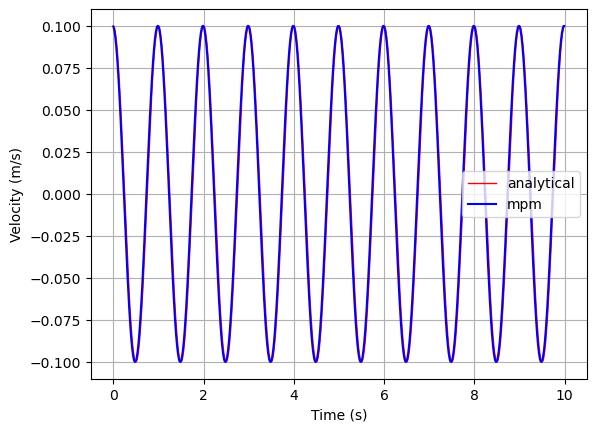

In [68]:
def analytical_vibration(E, rho, v0, x_loc, duration, dt, L):
    t = jnp.arange(0, duration, dt)
    omega = 1 / L * jnp.sqrt(E / rho)
    v = v0 * jnp.cos(omega * t)
    x = x_loc * jnp.exp(v0 / (L * omega) * jnp.sin(omega * t))
    return x, v, t


E = 4 * jnp.pi**2
x, v, t = analytical_vibration(E, 1, 0.1, 1, 10, 0.01, 1)
target = mpm(E)
fig, ax = plt.subplots()
ax.plot(t, v, "r", linewidth=1, label="analytical")
ax.plot(t, target, 'b', markersize=1, label='mpm')
ax.grid()
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity (m/s)")